In [23]:
import numpy as np
import pandas as pd
import math as m
import scipy as sp
from scipy.stats import norm
import scipy.integrate as spi
import scipy.optimize as spopt
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
from hyperopt import fmin, tpe, hp
from geneticalgorithm import geneticalgorithm as ga
from sko.PSO import PSO

In [2]:
np.random.seed(1)

# Data Processing

In [3]:
train = pd.read_csv('dec30.csv',usecols=[0,1,2,4,7,8,9])

In [4]:
train = train.dropna()
train

,date,symbol,exdate,strike_price,impl_volatility,mid,T
0,12/30/20,AAPL 210917C27500,9/17/21,27.50,0.871370,106.325,261.0
1,12/30/20,AAPL 210917C28750,9/17/21,28.75,0.847363,105.075,261.0
2,12/30/20,AAPL 210917C30000,9/17/21,30.00,0.824445,103.825,261.0
3,12/30/20,AAPL 210917C31250,9/17/21,31.25,0.802523,102.575,261.0
4,12/30/20,AAPL 210917C32500,9/17/21,32.50,0.781513,101.325,261.0
...,...,...,...,...,...,...,...
61,12/30/20,AAPL 210917C190000,9/17/21,190.00,0.374650,3.300,261.0
62,12/30/20,AAPL 210917C195000,9/17/21,195.00,0.377597,2.910,261.0
63,12/30/20,AAPL 210917C200000,9/17/21,200.00,0.381105,2.585,261.0
64,12/30/20,AAPL 210917C225000,9/17/21,225.00,0.402929,1.570,261.0


In [5]:
test = pd.read_csv('dec31.csv',usecols=[0,1,2,4,7,8,9])
test = test.dropna()
test

,date,symbol,exdate,strike_price,impl_volatility,mid,T
0,12/31/20,AAPL 210917C27500,9/17/21,27.50,0.937187,105.400,260.0
1,12/31/20,AAPL 210917C28750,9/17/21,28.75,0.923199,104.175,260.0
2,12/31/20,AAPL 210917C30000,9/17/21,30.00,0.898123,102.925,260.0
3,12/31/20,AAPL 210917C31250,9/17/21,31.25,0.874157,101.675,260.0
4,12/31/20,AAPL 210917C32500,9/17/21,32.50,0.851209,100.425,260.0
...,...,...,...,...,...,...,...
61,12/31/20,AAPL 210917C190000,9/17/21,190.00,0.366084,2.880,260.0
62,12/31/20,AAPL 210917C195000,9/17/21,195.00,0.368631,2.515,260.0
63,12/31/20,AAPL 210917C200000,9/17/21,200.00,0.373598,2.255,260.0
64,12/31/20,AAPL 210917C225000,9/17/21,225.00,0.397156,1.375,260.0


# Value Initialization

In [6]:
S1 = 132.90
S2 = 131.88

In [7]:
K1 = train.strike_price.tolist()
K2 = test.strike_price.tolist()

In [8]:
r = 0.0009
steps1 = 261
T1 = 261/365
steps2 = 260
T2 = 260/365

In [9]:
market_price1 = train.mid.tolist()
market_price2 = test.mid.tolist()
vol1 = train.impl_volatility.tolist()
vol2 = test.impl_volatility.tolist()

# Heston Model 

In [10]:
# Heston Model
def heston_model(S,T,r,steps,Npaths,k,theta,v_0,rho,xi):
    dt = T/steps
    stock = np.zeros((Npaths,steps))
    vol = np.zeros((Npaths,steps))
    S_t = S
    v_t = v_0
    for i in range(steps):
        W = np.random.multivariate_normal(np.array([0,0]),cov = np.array([[1,rho],[rho,1]]),
                                          size = Npaths)*np.sqrt(dt)
        S_t = S_t*(np.exp((r-v_t*0.5)*dt +np.sqrt(v_t)*W[:,0]))
        v_t = np.maximum(v_t+k*(theta-v_t)*dt + xi*np.sqrt(v_t)*W[:,1],0)
        stock[:,i] = S_t
        vol[:,i] = v_t

    return stock, vol

#For downhill simplex method
def Heston_C(kappa, theta, sigma, rho, v0, r, T, s0, K):
    a = s0*Heston_P(kappa, theta, sigma, rho, v0, r, T, s0, K, 1)
    b = K*np.exp(-r*T)*Heston_P(kappa, theta, sigma, rho, v0, r, T, s0, K, 2)    
    return a-b   
def Heston_P(kappa, theta, sigma, rho, v0, r, T, s0, K, type):
    ifun = lambda phi: Int_Function_1(phi, kappa, theta, sigma, rho, v0, r, T, s0, K, type)
    return 0.5 + (1/np.pi)*spi.quad(ifun, 0, 100)[0]
def Int_Function_1(phi, kappa, theta, sigma, rho, v0, r, T, s0, K, type):
    temp = (np.exp(-1*1j*phi*np.log(K))*Int_Function_2(phi, kappa, theta, sigma, rho, v0, r, T, s0, K, type))    
    return temp   
def Int_Function_2(phi, kappa, theta, sigma, rho, v0, r, T, s0, K, type):
    if type==1:
        u = 0.5
        b = kappa - rho*sigma
    else: 
        u = -0.5
        b = kappa
    a = kappa*theta
    x = np.log(s0)
    d = np.sqrt((rho*sigma*phi*1j-b)**2 - sigma**2*(2*u*phi*1j-phi**2))
    g = (b-rho*sigma*phi*1j+d)/(b-rho*sigma*phi*1j-d)
    D = r*phi*1j*T + (a/sigma**2)*((b-rho*sigma*phi*1j+d)*T - 2*np.log((1-g*np.exp(d*T))/(1-g)))
    E = ((b-rho*sigma*phi*1j+d)/sigma**2)*(1-np.exp(d*T))/(1-g*np.exp(d*T))
    return np.exp(D + E*v0 + 1j*phi*x)
def Heston_Option_Values(K, kappa, theta, sigma, rho, v0, r, T, s0):
    HOV = np.zeros(len(K), dtype=np.float)
    for i in range(len(K)):
        HOV[i] = Heston_C(kappa, theta, sigma, rho, v0, r, T, s0, K[i])
    return HOV
def Error_Function(p0, K, price, s0, r, T):
    kappa, theta, sigma, rho, v0 = p0
    price_e = np.zeros(len(K), np.float)
    
    for i in range(len(K)):
        price_e[i] = Heston_C(kappa, theta, sigma, rho, v0, r, T, s0, K[i])
    RMSE = np.sqrt(np.sum(price-price_e)**2/len(price))
    return RMSE

# Black-Scholes Model

In [11]:
#BS Model
def bs_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T)* norm.cdf(d2)

In [12]:
# Calculate bs price of test set
bs_price = []
for i in range(len(K2)):
    p = bs_call(S2,K2[i],T2,r,vol2[i])
    bs_price.append(p)

# Calibration

In [13]:
# Error function for optimization
def RMSE(true,predict):
    mse = np.square(np.subtract(true,predict)).mean()
    rmse = m.sqrt(mse)
    return rmse

## Tree-structured Parzen Estimator

In [14]:
# heston_model(S,T,r,steps, Npaths,k,theta,v_0,rho,xi)
def tpe_opt(market_price,S,K,T,r,steps, Npaths):
    # K is a list of strike price
    def objective(parameters):
        s,v = heston_model(S,T,r,steps,Npaths,**parameters)
        P = np.zeros((10000,len(K)))
        for i in range(len(K)):
            P[:,i] = np.maximum(s[:,-1] - K[i],0)

        P = np.mean(P,axis = 0)
        call_price = P*np.exp(-0.02*1)
        call_price = call_price.tolist()
        rmse = RMSE(bs_price,call_price)
        return rmse
    space = {
        'k': hp.uniform('k',0,1),
        'theta': hp.uniform('theta',0,1),
        'v_0': hp.uniform('v_0',0,1),
        'rho': hp.uniform('rho',0,1),
        'xi': hp.uniform('xi',0,5)
    }
    best = fmin(
        fn = objective,
        space = space,
        algo = tpe.suggest,
        max_evals = 1000
        )
    print(best)

In [15]:
tpe_opt(market_price1,S1,K1,T1,r,steps1,10000)

100%|██████████| 1000/1000 [04:06<00:00,  4.06trial/s, best loss: 0.5485948918794823]
{'k': 0.6505191042712305, 'rho': 0.09700380057253821, 'theta': 0.2309945037501921, 'v_0': 0.08253728158150937, 'xi': 0.11884259235593322}


In [16]:
para = {'k': 0.6505191042712305, 'rho': 0.09700380057253821, 'theta': 0.2309945037501921, 'v_0': 0.08253728158150937, 'xi': 0.11884259235593322}

In [17]:
s,v = heston_model(S2,T2,r,steps2,10000,**para)
P = np.zeros((10000,len(K2)))
for i in range(len(K2)):
    P[:,i] = np.maximum(s[:,-1] - K2[i],0)

P = np.mean(P,axis = 0)
tpe_call_price = P*np.exp(-r*1)
tpe_call_price = tpe_call_price.tolist()
print(tpe_call_price)

[104.1580455160816, 102.90917000998347, 101.66029450388528, 100.41141899778715, 99.16254349168904, 97.91366798559088, 96.66479247949276, 95.41591697339463, 94.16704146729647, 92.91816596119828, 91.66929045510011, 90.420414949002, 89.17153944290393, 87.92266393680572, 86.67378843070759, 85.42491292460936, 84.17605719583624, 82.92740385309327, 81.67895726380993, 79.18272045402738, 76.68841603485996, 74.19626062860567, 71.70715200495297, 69.22253279493991, 66.74311704961029, 64.2702982805253, 61.80669840495447, 59.35627586301348, 56.920058576241374, 54.50512791018701, 52.11493193832164, 49.75963216099426, 47.43812209908284, 45.15590169972223, 42.91491370505535, 40.714726741351406, 38.56632313651941, 36.475004324149694, 34.449106188306416, 32.48317602183893, 30.58173991742229, 28.74768438813171, 26.98747695974406, 25.303411298058577, 23.692220312689468, 22.152665482891326, 20.689650922136053, 19.300566305180308, 17.979232015395127, 15.55494866024691, 13.395433289567976, 11.49474388032156, 

## Bayesian Optimization

In [18]:
def bay_opt(bs_price,S,K,T,r,steps, Npaths):
    # K is a list of strike price
    def objective(k,theta,v_0,rho,xi):
        s,v = heston_model(S,T,r,steps, Npaths,k,theta,v_0,rho,xi)
        P = np.zeros((10000,len(K)))
        for i in range(len(K)):
            P[:,i] = np.maximum(s[:,-1] - K[i],0)

        P = np.mean(P,axis = 0)
        call_price = P*np.exp(-0.02*1)
        call_price = call_price.tolist()
        rmse = RMSE(bs_price,call_price)
        return -rmse
    pbounds = {
        'k': (0,1),
        'theta': (0,1),
        'v_0': (0,1),
        'rho': (0,1),
        'xi': (0,5)
    }
    optimizer = BayesianOptimization(
        f = objective,
        pbounds = pbounds,
        random_state=1111,
        )
    optimizer.maximize(init_points=20, n_iter=1000)
    print(optimizer.max)

In [20]:
bay_opt(market_price1,S1,K1,T1,r,steps1,10000)

|   iter    |  target   |     k     |    rho    |   theta   |    v_0    |    xi     |
-------------------------------------------------------------------------------------
|  1        | -4.384    |  0.09555  |  0.925    |  0.3436   |  0.3105   |  0.01005  |
|  2        | -5.887    |  0.2356   |  0.2378   |  0.7359   |  0.4955   |  3.922    |
|  3        | -3.874    |  0.1265   |  0.6066   |  0.4661   |  0.2371   |  2.176    |
|  4        | -11.42    |  0.2437   |  0.3838   |  0.8384   |  0.6552   |  0.7422   |
|  5        | -11.8     |  0.6391   |  0.6374   |  0.6109   |  0.93     |  4.082    |
|  6        | -8.549    |  0.7694   |  0.0854   |  0.665    |  0.7117   |  4.437    |
|  7        | -5.378    |  0.268    |  0.2431   |  0.7893   |  0.378    |  3.972    |
|  8        | -7.991    |  0.8673   |  0.7958   |  0.9172   |  0.2711   |  3.804    |
|  9        | -2.848    |  0.6304   |  0.07933  |  0.1309   |  0.3003   |  1.611    |
|  10       | -8.509    |  0.1611   |  0.3152   |  0.5

|  58       | -8.206    |  0.509    |  0.3229   |  0.4081   |  0.8643   |  4.742    |
|  59       | -10.36    |  0.04039  |  0.2924   |  0.6633   |  0.6103   |  1.327    |
|  60       | -5.836    |  0.0275   |  0.4986   |  0.3996   |  0.0      |  0.5854   |
|  61       | -3.945    |  0.443    |  0.000885 |  0.1918   |  0.0      |  1.732    |
|  62       | -9.501    |  0.6816   |  0.09207  |  0.7641   |  0.6118   |  2.479    |
|  63       | -1.415    |  0.6532   |  0.1714   |  0.747    |  0.0      |  1.554    |
|  64       | -4.482    |  0.07934  |  0.0164   |  0.02032  |  0.05717  |  0.9012   |
|  65       | -11.68    |  0.3644   |  0.3763   |  0.4838   |  0.8393   |  1.268    |
|  66       | -12.15    |  0.2572   |  0.4514   |  0.9213   |  0.9799   |  3.167    |
|  67       | -2.397    |  0.8613   |  0.3401   |  0.6908   |  0.0      |  1.852    |
|  68       | -11.12    |  0.4844   |  0.8994   |  0.2439   |  0.745    |  3.974    |
|  69       | -7.646    |  0.1355   |  0.6683   |  0.9

|  116      | -2.869    |  0.6654   |  0.4084   |  0.5231   |  0.0      |  1.019    |
|  117      | -2.313    |  0.7449   |  0.1587   |  0.7915   |  0.0      |  0.0      |
|  118      | -3.626    |  0.1963   |  0.8524   |  0.1753   |  0.1958   |  1.242    |
|  119      | -16.12    |  0.112    |  0.8318   |  0.2915   |  0.9386   |  0.2261   |
|  120      | -5.714    |  0.6261   |  0.2535   |  0.0609   |  0.5617   |  2.634    |
|  121      | -8.77     |  0.76     |  0.8393   |  0.3064   |  0.5166   |  2.362    |
|  122      | -5.035    |  0.5331   |  0.1742   |  0.5115   |  0.2173   |  4.888    |
|  123      | -8.38     |  0.5509   |  0.3532   |  0.5926   |  0.6269   |  2.802    |
|  124      | -2.468    |  0.5116   |  0.2624   |  0.3555   |  0.1076   |  0.8899   |
|  125      | -13.62    |  0.121    |  0.9231   |  0.4599   |  0.8509   |  4.419    |
|  126      | -9.084    |  0.6938   |  0.09454  |  0.8835   |  0.453    |  2.737    |
|  127      | -8.839    |  0.124    |  0.2845   |  0.4

|  174      | -4.329    |  0.5782   |  0.0875   |  0.4007   |  0.3324   |  2.13     |
|  175      | -5.201    |  1.0      |  1.0      |  0.7148   |  0.0      |  2.655    |
|  176      | -33.06    |  0.2465   |  0.6584   |  0.1387   |  0.1622   |  3.757    |
|  177      | -3.881    |  0.6727   |  0.1314   |  0.09833  |  0.4168   |  3.771    |
|  178      | -2.827    |  0.047    |  0.191    |  0.59     |  0.1545   |  3.854    |
|  179      | -3.014    |  0.4948   |  0.1799   |  0.02824  |  0.3148   |  2.459    |
|  180      | -4.85     |  0.3211   |  0.03423  |  0.9649   |  0.3535   |  4.872    |
|  181      | -2.064    |  1.0      |  0.2533   |  0.6489   |  0.0      |  0.3123   |
|  182      | -3.35     |  0.1701   |  0.1658   |  0.5069   |  0.2548   |  2.935    |
|  183      | -2.239    |  0.7884   |  0.166    |  0.505    |  0.0      |  2.308    |
|  184      | -2.103    |  0.4204   |  0.0      |  0.0      |  0.3747   |  4.051    |
|  185      | -16.27    |  0.7687   |  0.2552   |  0.8

|  232      | -12.22    |  0.7655   |  0.02611  |  0.2634   |  0.7713   |  0.1777   |
|  233      | -6.21     |  0.0      |  0.0      |  0.8094   |  0.0      |  5.0      |
|  234      | -2.91     |  0.922    |  0.4074   |  0.6949   |  0.04685  |  0.2482   |
|  235      | -1.997    |  1.0      |  0.0      |  0.4167   |  0.0      |  3.999    |
|  236      | -8.311    |  0.001674 |  0.06942  |  0.08988  |  0.549    |  1.024    |
|  237      | -2.164    |  0.9419   |  0.04099  |  0.06184  |  0.142    |  2.453    |
|  238      | -3.701    |  0.6054   |  0.07698  |  0.1645   |  0.3717   |  2.088    |
|  239      | -3.717    |  0.9692   |  0.3738   |  0.03761  |  0.06971  |  2.862    |
|  240      | -16.49    |  0.656    |  0.5438   |  0.3759   |  0.9582   |  1.073    |
|  241      | -6.21     |  1.0      |  0.3303   |  0.0      |  0.0      |  3.966    |
|  242      | -9.592    |  0.5424   |  0.9013   |  0.1134   |  0.5717   |  4.987    |
|  243      | -3.261    |  0.2389   |  0.6653   |  0.2

|  290      | -5.891    |  0.2067   |  0.3307   |  0.05855  |  0.5943   |  3.359    |
|  291      | -5.453    |  0.6146   |  0.2884   |  0.3981   |  0.4069   |  2.511    |
|  292      | -9.886    |  0.1178   |  0.5129   |  0.9814   |  0.5089   |  2.047    |
|  293      | -3.143    |  0.8118   |  0.02947  |  0.3797   |  0.2537   |  3.754    |
|  294      | -3.023    |  0.7205   |  0.76     |  0.6151   |  0.03073  |  1.56     |
|  295      | -3.539    |  0.2652   |  0.0      |  0.7874   |  0.0      |  1.648    |
|  296      | -7.603    |  0.8675   |  0.9239   |  0.4901   |  0.3642   |  2.958    |
|  297      | -8.742    |  0.8034   |  0.09074  |  0.06015  |  0.8262   |  3.684    |
|  298      | -3.348    |  0.3514   |  0.4914   |  0.7511   |  0.0      |  0.5861   |
|  299      | -3.865    |  0.9143   |  0.2571   |  0.2839   |  0.1936   |  3.636    |
|  300      | -11.45    |  0.9024   |  0.1572   |  0.2228   |  0.9724   |  2.696    |
|  301      | -3.895    |  1.0      |  0.6162   |  0.2

|  348      | -2.788    |  0.3655   |  0.4369   |  0.6669   |  0.003431 |  1.319    |
|  349      | -1.975    |  0.3223   |  0.0      |  1.0      |  0.0      |  3.229    |
|  350      | -6.562    |  0.9602   |  0.8505   |  0.591    |  0.1079   |  3.96     |
|  351      | -4.493    |  0.9955   |  0.5156   |  0.1127   |  0.26     |  4.057    |
|  352      | -14.84    |  0.5357   |  0.9135   |  0.8151   |  0.9968   |  4.061    |
|  353      | -2.554    |  0.0      |  0.2961   |  0.0      |  0.2084   |  2.429    |
|  354      | -16.77    |  0.6016   |  0.9014   |  0.8761   |  0.9826   |  1.463    |
|  355      | -6.21     |  0.0      |  0.4654   |  0.5592   |  0.0      |  3.076    |
|  356      | -12.6     |  0.5832   |  0.7736   |  0.08008  |  0.9113   |  0.5616   |
|  357      | -6.917    |  0.5398   |  0.7833   |  0.8017   |  0.213    |  4.125    |
|  358      | -3.747    |  0.3853   |  0.8359   |  0.8731   |  0.141    |  1.002    |
|  359      | -7.812    |  0.4019   |  0.5341   |  0.0

|  406      | -11.05    |  0.9307   |  0.9316   |  0.2074   |  0.7366   |  0.9752   |
|  407      | -14.29    |  0.1272   |  0.5956   |  0.5778   |  0.9815   |  2.218    |
|  408      | -3.687    |  0.9518   |  0.1049   |  0.8923   |  0.01178  |  2.685    |
|  409      | -17.46    |  0.1061   |  0.7916   |  0.4807   |  0.008123 |  4.431    |
|  410      | -14.49    |  0.6613   |  0.3272   |  0.9939   |  0.9102   |  1.113    |
|  411      | -14.59    |  0.1749   |  0.5261   |  0.3124   |  0.9101   |  1.442    |
|  412      | -8.293    |  0.1187   |  0.9743   |  0.1818   |  0.1063   |  4.407    |
|  413      | -6.21     |  1.0      |  1.0      |  0.0      |  0.0      |  1.367    |
|  414      | -3.71     |  0.0      |  0.4098   |  0.7494   |  0.3412   |  4.661    |
|  415      | -7.782    |  0.5888   |  0.1773   |  0.408    |  0.539    |  1.689    |
|  416      | -12.92    |  0.2335   |  0.7263   |  0.08762  |  0.815    |  4.946    |
|  417      | -15.37    |  0.3163   |  0.9989   |  0.6

|  464      | -4.288    |  0.17     |  0.1784   |  0.0626   |  0.3573   |  1.024    |
|  465      | -5.36     |  0.1283   |  0.9622   |  0.9448   |  0.09197  |  3.628    |
|  466      | -3.181    |  0.3305   |  0.3386   |  0.3824   |  0.06656  |  0.2006   |
|  467      | -6.21     |  0.0      |  1.0      |  0.4865   |  0.0      |  1.055    |
|  468      | -3.803    |  0.8971   |  0.1074   |  0.001077 |  0.5423   |  3.235    |
|  469      | -4.017    |  0.1755   |  0.6677   |  0.3995   |  0.2595   |  1.753    |
|  470      | -3.422    |  0.7384   |  0.2031   |  0.8464   |  0.0486   |  3.156    |
|  471      | -8.864    |  0.6152   |  0.6478   |  0.1386   |  0.6353   |  4.152    |
|  472      | -13.09    |  0.1654   |  0.8093   |  0.6733   |  0.9626   |  3.522    |
|  473      | -3.049    |  0.0      |  0.5209   |  0.0      |  0.2124   |  0.8296   |
|  474      | -3.071    |  1.0      |  1.0      |  0.5801   |  0.0      |  1.425    |
|  475      | -3.863    |  0.453    |  0.0      |  1.0

|  522      | -9.035    |  0.8071   |  0.9469   |  0.7692   |  0.3452   |  3.499    |
|  523      | -2.994    |  0.4922   |  0.3023   |  0.1536   |  0.02594  |  4.247    |
|  524      | -8.745    |  0.9788   |  0.2924   |  0.5801   |  0.5339   |  1.222    |
|  525      | -5.46     |  0.8861   |  0.3648   |  0.7913   |  0.2349   |  1.943    |
|  526      | -9.702    |  0.598    |  0.7863   |  0.1876   |  0.6404   |  0.9809   |
|  527      | -10.58    |  0.961    |  0.899    |  0.785    |  0.3163   |  4.918    |
|  528      | -4.34     |  0.5195   |  0.3407   |  0.2559   |  0.1503   |  4.87     |
|  529      | -10.71    |  0.5141   |  0.5573   |  0.2216   |  0.6423   |  0.9774   |
|  530      | -3.182    |  0.3019   |  0.4303   |  0.6978   |  0.1932   |  1.352    |
|  531      | -4.836    |  0.3072   |  0.04267  |  0.3708   |  0.397    |  4.381    |
|  532      | -16.11    |  0.121    |  0.9781   |  0.5249   |  0.9615   |  3.347    |
|  533      | -5.166    |  0.1101   |  0.02685  |  0.3

|  580      | -8.761    |  1.0      |  0.0      |  0.0      |  0.9059   |  1.831    |
|  581      | -2.022    |  0.0      |  0.0      |  0.33     |  0.2777   |  2.214    |
|  582      | -2.464    |  0.0      |  0.0      |  1.0      |  0.5316   |  4.527    |
|  583      | -6.818    |  0.3422   |  0.1908   |  0.6465   |  0.4469   |  1.176    |
|  584      | -9.21     |  0.0      |  1.0      |  0.0      |  0.4537   |  0.9953   |
|  585      | -4.538    |  0.6339   |  0.0      |  1.0      |  0.1679   |  0.5761   |
|  586      | -6.21     |  0.0      |  0.0      |  1.0      |  0.0      |  3.451    |
|  587      | -3.095    |  1.0      |  0.3881   |  0.0      |  0.3348   |  0.4706   |
|  588      | -6.242    |  0.3339   |  0.0      |  1.0      |  0.3752   |  4.441    |
|  589      | -6.21     |  0.0      |  0.0      |  0.3904   |  0.0      |  2.996    |
|  590      | -7.288    |  0.8275   |  0.9526   |  0.9011   |  0.2889   |  0.3373   |
|  591      | -5.639    |  0.2344   |  0.3477   |  0.0

|  638      | -2.989    |  1.0      |  0.5193   |  0.6526   |  0.0      |  0.9299   |
|  639      | -6.775    |  0.7706   |  0.745    |  0.9346   |  0.2562   |  1.705    |
|  640      | -6.21     |  0.0      |  0.4212   |  0.6315   |  0.0      |  3.657    |
|  641      | -2.743    |  0.5467   |  0.3688   |  0.1452   |  0.1633   |  1.225    |
|  642      | -5.976    |  0.3231   |  0.5774   |  0.9402   |  0.3132   |  0.6812   |
|  643      | -6.258    |  0.3796   |  0.784    |  0.1498   |  0.3815   |  1.226    |
|  644      | -3.304    |  0.232    |  0.0      |  0.9357   |  0.2864   |  3.003    |
|  645      | -1.996    |  0.9453   |  0.01557  |  0.6384   |  0.04875  |  1.297    |
|  646      | -3.573    |  0.07411  |  0.2412   |  0.179    |  0.05384  |  2.668    |
|  647      | -4.04     |  0.2713   |  0.6016   |  0.5923   |  0.1397   |  2.984    |
|  648      | -3.429    |  0.7366   |  0.0      |  0.3588   |  0.0      |  0.9961   |
|  649      | -4.57     |  0.0      |  0.0      |  0.0

|  696      | -6.082    |  0.7861   |  0.7999   |  0.6575   |  0.2398   |  2.76     |
|  697      | -4.915    |  0.01886  |  0.01808  |  0.9667   |  0.3556   |  3.801    |
|  698      | -16.43    |  0.05952  |  0.6562   |  0.5124   |  0.9976   |  2.117    |
|  699      | -11.27    |  0.7433   |  0.6611   |  0.5026   |  0.6758   |  2.976    |
|  700      | -30.24    |  0.06621  |  0.7713   |  0.08187  |  0.7512   |  4.836    |
|  701      | -6.21     |  0.0      |  1.0      |  1.0      |  0.0      |  1.913    |
|  702      | -6.21     |  0.0      |  0.0      |  0.0      |  0.0      |  3.999    |
|  703      | -10.83    |  0.6175   |  0.07287  |  0.8533   |  0.7721   |  2.923    |
|  704      | -4.103    |  0.8917   |  0.0      |  1.0      |  0.0      |  4.528    |
|  705      | -4.323    |  0.4206   |  0.6274   |  0.2727   |  0.06837  |  4.112    |
|  706      | -2.337    |  0.5114   |  0.0      |  0.0      |  0.5242   |  5.0      |
|  707      | -9.66     |  0.62     |  0.3579   |  0.5

|  754      | -2.356    |  0.2881   |  0.0      |  0.7326   |  0.0      |  4.739    |
|  755      | -2.397    |  0.07303  |  0.01025  |  0.3446   |  0.218    |  1.449    |
|  756      | -6.652    |  0.5896   |  0.4623   |  0.2626   |  0.542    |  4.313    |
|  757      | -4.299    |  0.2947   |  0.419    |  1.0      |  0.2067   |  2.833    |
|  758      | -7.162    |  0.000885 |  0.7242   |  0.8163   |  0.4335   |  1.104    |
|  759      | -1.855    |  0.0      |  0.0      |  1.0      |  0.1618   |  0.7149   |
|  760      | -1.692    |  0.3046   |  0.022    |  0.4926   |  0.01021  |  3.424    |
|  761      | -6.153    |  0.5331   |  0.09374  |  0.4848   |  0.3369   |  4.024    |
|  762      | -2.616    |  0.4535   |  0.2297   |  1.0      |  0.0      |  0.0      |
|  763      | -3.302    |  0.2998   |  0.0      |  1.0      |  0.2044   |  0.9408   |
|  764      | -3.192    |  0.6345   |  0.3246   |  0.0      |  0.53     |  5.0      |
|  765      | -4.718    |  0.7431   |  0.06957  |  0.9

|  812      | -2.159    |  0.6513   |  0.0      |  0.0      |  0.2735   |  4.802    |
|  813      | -2.611    |  0.5689   |  0.2525   |  0.5197   |  0.1184   |  3.025    |
|  814      | -6.556    |  0.2233   |  0.5375   |  0.9989   |  0.09164  |  4.963    |
|  815      | -6.655    |  0.5551   |  0.7623   |  1.0      |  0.0      |  5.0      |
|  816      | -3.447    |  0.5632   |  0.2066   |  1.0      |  0.0      |  3.538    |
|  817      | -5.235    |  1.0      |  1.0      |  0.3601   |  0.2829   |  0.5083   |
|  818      | -7.115    |  0.1676   |  0.6722   |  0.01398  |  0.5045   |  4.818    |
|  819      | -12.96    |  0.5238   |  0.4382   |  0.2327   |  0.7822   |  1.327    |
|  820      | -9.48     |  0.9226   |  0.5953   |  0.1504   |  0.7466   |  1.197    |
|  821      | -3.113    |  0.7337   |  0.001526 |  0.2587   |  0.2275   |  4.135    |
|  822      | -2.109    |  0.674    |  0.2193   |  0.2421   |  0.1507   |  0.3994   |
|  823      | -5.947    |  0.2843   |  0.7937   |  0.7

|  870      | -12.46    |  0.9168   |  0.07882  |  0.3773   |  0.8299   |  0.1354   |
|  871      | -8.165    |  0.2189   |  0.4362   |  0.254    |  0.6716   |  4.863    |
|  872      | -4.15     |  1.0      |  0.3116   |  0.5344   |  0.0      |  3.911    |
|  873      | -3.59     |  0.8158   |  0.03311  |  0.6711   |  0.01596  |  4.972    |
|  874      | -3.181    |  0.7258   |  0.3811   |  0.5567   |  0.0      |  1.386    |
|  875      | -6.817    |  0.3959   |  0.8396   |  0.9142   |  0.2212   |  3.825    |
|  876      | -2.366    |  0.6514   |  0.0      |  0.3416   |  0.0      |  5.0      |
|  877      | -5.242    |  0.3222   |  1.0      |  0.2453   |  0.0      |  0.536    |
|  878      | -6.148    |  0.4782   |  0.3991   |  0.0      |  0.9115   |  5.0      |
|  879      | -7.435    |  1.0      |  1.0      |  0.0      |  0.3587   |  3.321    |
|  880      | -4.071    |  0.4744   |  1.0      |  0.4695   |  0.2666   |  0.0      |
|  881      | -12.48    |  0.1433   |  0.7258   |  0.8

|  928      | -9.959    |  0.03664  |  0.1923   |  0.3636   |  0.7433   |  1.792    |
|  929      | -4.709    |  0.6688   |  1.0      |  0.0      |  0.3666   |  0.5509   |
|  930      | -13.62    |  0.08599  |  0.8497   |  0.5295   |  0.9395   |  3.559    |
|  931      | -3.868    |  1.0      |  0.2619   |  1.0      |  0.0      |  1.024    |
|  932      | -15.5     |  1.0      |  0.68     |  1.0      |  1.0      |  4.408    |
|  933      | -4.018    |  1.0      |  1.0      |  0.2295   |  0.204    |  1.004    |
|  934      | -3.136    |  0.4083   |  0.2211   |  1.0      |  0.0      |  3.997    |
|  935      | -6.21     |  0.0      |  1.0      |  0.2884   |  0.0      |  0.2107   |
|  936      | -11.1     |  0.9101   |  0.6983   |  0.9762   |  0.5138   |  0.06788  |
|  937      | -3.924    |  0.4744   |  0.3642   |  0.2433   |  0.1626   |  4.821    |
|  938      | -2.913    |  0.6933   |  0.2231   |  0.6575   |  0.0      |  3.722    |
|  939      | -15.03    |  0.4635   |  0.9672   |  0.8

|  986      | -2.838    |  1.0      |  0.2463   |  0.6961   |  0.0      |  2.952    |
|  987      | -3.236    |  0.0      |  0.358    |  0.2767   |  0.338    |  2.71     |
|  988      | -3.475    |  0.5013   |  0.5021   |  0.9258   |  0.1384   |  0.1165   |
|  989      | -3.201    |  0.06664  |  0.7308   |  0.7806   |  0.09113  |  2.195    |
|  990      | -1.478    |  0.8137   |  0.01824  |  0.3948   |  0.005653 |  3.114    |
|  991      | -2.984    |  0.6908   |  0.1278   |  0.723    |  0.1218   |  0.3319   |
|  992      | -7.784    |  0.558    |  0.4907   |  0.2113   |  0.4929   |  0.2993   |
|  993      | -2.188    |  0.0      |  0.0      |  0.0      |  0.4715   |  5.0      |
|  994      | -10.41    |  0.2236   |  0.5655   |  0.539    |  0.9556   |  4.13     |
|  995      | -3.706    |  1.0      |  0.0      |  0.4394   |  0.0      |  4.653    |
|  996      | -5.415    |  0.0      |  0.0      |  0.7229   |  0.5092   |  2.117    |
|  997      | -3.261    |  0.0      |  0.2553   |  0.4

In [34]:
para2 = {'k': 1, 'rho': 0, 'theta': 0.608598513215922, 'v_0': 0, 'xi': 1.6872869663502892}

In [35]:
s2,v2 = heston_model(S2,T2,r,steps2,10000,**para2)
P2 = np.zeros((10000,len(K2)))
for i in range(len(K2)):
    P2[:,i] = np.maximum(s2[:,-1] - K2[i],0)

P2 = np.mean(P2,axis = 0)
bayes_call_price = P2*np.exp(-r*1)
bayes_call_price = bayes_call_price.tolist()
print(bayes_call_price)

[104.3887772173913, 103.14566748864847, 101.90323001146355, 100.66171132531565, 99.42103305358539, 98.18154658011719, 96.94255989388554, 95.70456611815179, 94.46747900838375, 93.23205567706079, 91.99776930541198, 90.76445531434005, 89.5324733871174, 88.3023598674255, 87.07357053859882, 85.84658162940883, 84.62154472088369, 83.39846822626453, 82.17719683080271, 79.74037875185705, 77.31209001199979, 74.89260572380016, 72.48428717266097, 70.08905291553549, 67.70651432979119, 65.33994558747091, 62.98863449893256, 60.652719552925795, 58.334882336232205, 56.03979615634614, 53.768905486559575, 51.52310992366237, 49.30576960950755, 47.120737573237236, 44.96945507584998, 42.852894823000746, 40.7786266918092, 38.750946708354604, 36.77146204439414, 34.84286218801599, 32.968305356310864, 31.14876306925719, 29.385955494445763, 27.68941779173426, 26.058428317098933, 24.49947589538065, 23.01601273194885, 21.607868379480617, 20.273174877160173, 17.81498455848765, 15.624893724348372, 13.703860589210429

## Genetic Algorithm

In [21]:
def ga_opt(bs_price,S,K,T,r,steps, Npaths):
    # K is a list of strike price
    def objective(X):
        s,v = heston_model(S,T,r,steps, Npaths,X[0],X[1],X[2],X[3],X[4])
        P = np.zeros((10000,len(K)))
        for i in range(len(K)):
            P[:,i] = np.maximum(s[:,-1] - K[i],0)

        P = np.mean(P,axis = 0)
        call_price = P*np.exp(-0.02*1)
        call_price = call_price.tolist()
        rmse = RMSE(bs_price,call_price)
        return rmse
    varbound = np.array([[0,1],[0,1],[0,1],[0,1],[0,5]])
    algorithm_param = {'max_num_iteration': 200,
                   'population_size':100,
                   'mutation_probability':0.1,
                   'elit_ratio': 0.01,
                   'crossover_probability': 0.5,
                   'parents_portion': 0.3,
                   'crossover_type':'uniform',
                   'max_iteration_without_improv':None}

    model = ga(function=objective,dimension=5,variable_type='real',variable_boundaries=varbound,algorithm_parameters=algorithm_param)
    model.run()

 The best solution found:                                                                           
 [0.05650896 0.79042834 0.14088824 0.00974928 1.86100029]

 Objective function:
 0.9783973537482937


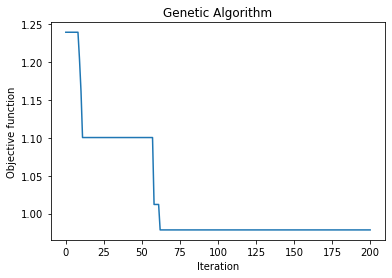

In [22]:
ga_opt(market_price1,S1,K1,T1,r,steps1,10000)

In [24]:
#para3 = {'k': 0.00073419, 'rho': 0.06236637, 'theta': 0.00405447, 'v_0': 0.01519778, 'xi': 0.24350673}
para3 = {'k': 0.05650896, 'rho': 0.79042834, 'theta': 0.14088824, 'v_0': 0.00974928, 'xi': 1.86100029}

In [25]:
s3,v3 = heston_model(S2,T2,r,steps2,10000,**para3)
P3 = np.zeros((10000,len(K2)))
for i in range(len(K2)):
    P3[:,i] = np.maximum(s3[:,-1] - K2[i],0)

P3 = np.mean(P3,axis = 0)
ga_call_price = P3*np.exp(-r*1)
ga_call_price = ga_call_price.tolist()
print(ga_call_price)

[103.68782445146243, 102.43894894536432, 101.19007343926611, 99.941197933168, 98.69232242706983, 97.44344692097164, 96.19457141487344, 94.94576916686816, 93.69701854832059, 92.44826792977304, 91.19956495340408, 89.95093922240716, 88.7023134914102, 87.45368776041327, 86.20506202941642, 84.9564362984195, 83.70785319675424, 82.45935235330792, 81.21094202787948, 78.71437132049249, 76.21843797853465, 73.72310835362069, 71.22787396140347, 68.7334306672627, 66.23977967728428, 63.74677439201123, 61.25390394732547, 58.76215624160713, 56.27170474009418, 53.7827361820634, 51.295857298343535, 48.81125387542478, 46.32926401453273, 43.85042591048847, 41.37463404480991, 38.90266245265042, 36.43532687915803, 33.973969716914354, 31.51781463815349, 29.07141298315384, 26.636303180923036, 24.216347428640276, 21.81522712565056, 19.44020799215304, 17.099286308446818, 14.81239845953707, 12.624358957518714, 10.606720200056193, 8.880758568945184, 6.630261045430215, 5.469659440383628, 4.756986322419848, 4.25775

## Downhill Simplex Algorithm

In [30]:
price = market_price1

p0 = np.array([1.0, 0.05, 0.15,-0.7, 0.04]) # initial guess for parameters
opt = spopt.fmin(Error_Function, p0, maxiter=75, maxfun=75, args=(K1, price, S1, r, T1))
print(opt)

<ipython-input-10-372b054bd36f>:50: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  price_e = np.zeros(len(K), np.float)
/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/quadpack.py:463: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


[ 1.08965979  0.05620208  0.17126824 -1.06209853  0.01828358]


In [31]:
para4 = {'k':1.08965979 , 'rho':-1.06209853 , 'theta':0.05620208 , 'v_0':0.01828358, 'xi':0.17126824}

In [32]:
s4,v4 = heston_model(S2,T2,r,steps2,10000,**para4)
P4 = np.zeros((10000,len(K2)))
for i in range(len(K2)):
    P4[:,i] = np.maximum(s4[:,-1] - K2[i],0)

P4 = np.mean(P4,axis = 0)
ds_call_price = P4*np.exp(-r*1)
ds_call_price = ds_call_price.tolist()
print(ds_call_price)

<ipython-input-10-372b054bd36f>:9: RuntimeWarning: covariance is not positive-semidefinite.
  W = np.random.multivariate_normal(np.array([0,0]),cov = np.array([[1,rho],[rho,1]]),


[104.39900725239904, 103.15013174630084, 101.90125624020268, 100.65238073410454, 99.40350522800641, 98.15462972190822, 96.90575421581012, 95.65687870971198, 94.40800320361382, 93.15912769751571, 91.91025219141746, 90.66137668531933, 89.41250117922117, 88.16362567312301, 86.91475016702485, 85.6658746609267, 84.41699915482853, 83.16812364873034, 81.91924814263218, 79.42150509021961, 76.9240038531245, 74.42657798669646, 71.92952092233926, 69.43301260521007, 66.93651046851997, 64.44058212321427, 61.9463242979739, 59.4537403359727, 56.963955821164724, 54.47793063271096, 51.9955073562771, 49.51882120749676, 47.04767683404255, 44.584556895750616, 42.132301758306504, 39.692488571851065, 37.27052975278234, 34.86909787317722, 32.495577152799065, 30.155020921437636, 27.853527957780855, 25.59871044215247, 23.396841103157342, 21.256362885640087, 19.182578862523968, 17.192373790877063, 15.293529934301352, 13.493648589633995, 11.79186217201436, 8.722809245781038, 6.1392253121613205, 4.076491883818782

## Particle Swarm Optimization

In [26]:
def pso_opt(bs_price,S,K,T,r,steps, Npaths):
    # K is a list of strike price
    def objective(k,theta,v_0,rho,xi):
        s,v = heston_model(S,T,r,steps, Npaths,k,theta,v_0,rho,xi)
        P = np.zeros((10000,len(K)))
        for i in range(len(K)):
            P[:,i] = np.maximum(s[:,-1] - K[i],0)


        P = np.mean(P,axis = 0)
        call_price = P*np.exp(-0.02*1)
        call_price = call_price.tolist()
        rmse = RMSE(bs_price,call_price)
        return rmse
    pso = PSO(func=objective, n_dim=5, pop=40, max_iter=150, lb = [0, 0, 0,0,0],
    ub = [1, 1, 1,1,5])
    pso.run()
    print(pso.gbest_x)

In [27]:
pso_opt(market_price1,S1,K1,T1,r,steps1,10000)

/opt/anaconda3/lib/python3.8/site-packages/sko/tools.py:56: UserWarning: multi-input might be deprecated in the future, use fun(p) instead
  warnings.warn('multi-input might be deprecated in the future, use fun(p) instead')


[1.         0.36594382 0.         0.         2.66018096]


In [28]:
para5 = {'k':1 , 'rho':0.36594382 , 'theta':0 , 'v_0':0, 'xi':2.66018096}

In [29]:
s5,v5 = heston_model(S2,T2,r,steps2,10000,**para5)
P5 = np.zeros((10000,len(K2)))
for i in range(len(K2)):
    P5[:,i] = np.maximum(s5[:,-1] - K2[i],0)

P5 = np.mean(P5,axis = 0)
pso_call_price = P5*np.exp(-r*1)
pso_call_price = pso_call_price.tolist()
print(pso_call_price)

[104.37059901151927, 103.12172350542117, 101.87284799932308, 100.623972493225, 99.37509698712692, 98.12622148102884, 96.87734597493076, 95.62847046883267, 94.37959496273459, 93.13071945663651, 91.88184395053845, 90.63296844444037, 89.3840929383423, 88.13521743224422, 86.88634192614616, 85.6374664200481, 84.38859091395004, 83.13971540785198, 81.89083990175394, 79.39308888955783, 76.89533787736175, 74.39758686516569, 71.89983585296964, 69.40208484077363, 66.9043338285776, 64.40658281638163, 61.90883180418568, 59.41108079198976, 56.913329779793855, 54.415578767598014, 51.9178277554022, 49.42007674320645, 46.92232573101076, 44.424574718815144, 41.926823706619594, 39.42907269442415, 36.931321682228834, 34.43357067003366, 31.935819657838657, 29.43806864564388, 26.94031763344939, 24.442566621253196, 21.944815609056036, 19.447064596858656, 16.94931358466097, 14.451562572462805, 11.953811560265258, 9.456060548069152, 6.958309535873193, 1.9628075114816004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

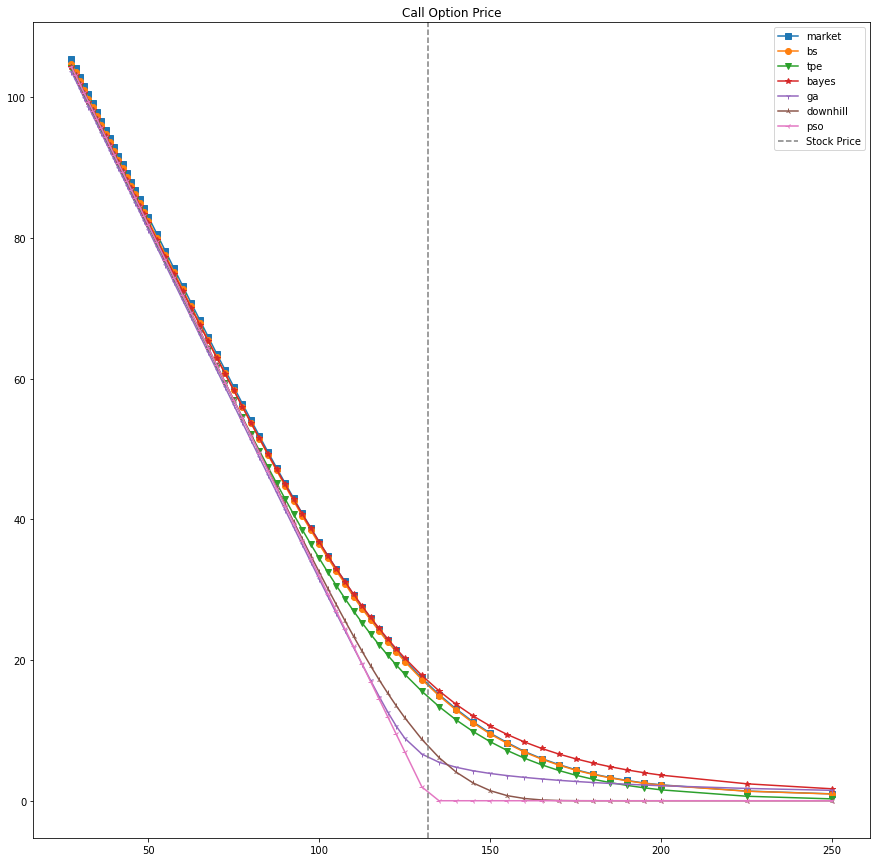

In [51]:
plt.figure(figsize=(15,15))
plt.plot(K2,market_price2,'s-',label='market')
plt.plot(K2,bs_price,'o-',label='bs')
plt.plot(K2,tpe_call_price,'v-',label='tpe')
plt.plot(K2,bayes_call_price,'*-',label='bayes')
plt.plot(K2,ga_call_price,'1-',label='ga')
plt.plot(K2,ds_call_price,'2-',label='downhill')
plt.plot(K2,pso_call_price,'3-',label='pso')
plt.axvline(x=S2,color='grey',linestyle='--',label='Stock Price')
plt.legend()
plt.title('Call Option Price')
plt.show()

In [37]:
def DIFF(real,predict):
    diff = []
    for i in range(len(real)):
        d = abs(real[i] - predict[i])
        diff.append(d)
    return diff

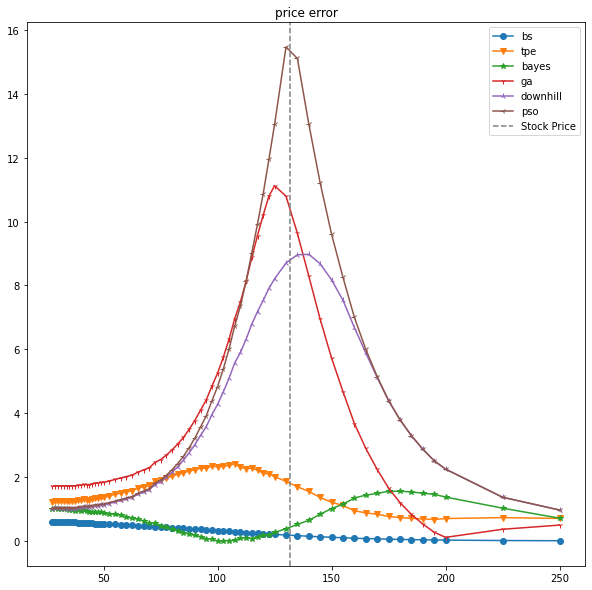

In [50]:
plt.figure(figsize=(10,10))
plt.plot(K2,DIFF(market_price2,bs_price),'o-',label='bs')
plt.plot(K2,DIFF(market_price2,tpe_call_price),'v-',label='tpe')
plt.plot(K2,DIFF(market_price2,bayes_call_price),'*-',label='bayes')
plt.plot(K2,DIFF(market_price2,ga_call_price),'1-',label='ga')
plt.plot(K2,DIFF(market_price2,ds_call_price),'2-',label='downhill')
plt.plot(K2,DIFF(market_price2,pso_call_price),'3-',label='pso')
plt.axvline(x=S2,color='grey',linestyle='--',label='Stock Price')
plt.legend()
plt.title('price error')
plt.show()

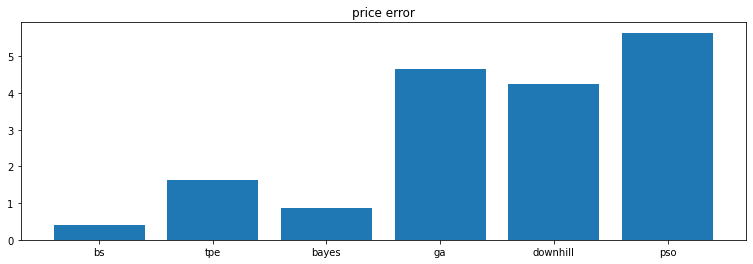

In [49]:
x = np.arange(6)
x_name = ['bs','tpe','bayes','ga','downhill','pso']
y = [RMSE(market_price2,bs_price),RMSE(market_price2,tpe_call_price),RMSE(market_price2,bayes_call_price),RMSE(market_price2,ga_call_price),RMSE(market_price2,ds_call_price),RMSE(market_price2,pso_call_price)]
plt.figure(figsize=(13,4))
plt.bar(x,y)
plt.xticks(x, x_name)
plt.title('price error')
plt.show()